<a href="https://colab.research.google.com/github/justincheng101/LBNL_Internship/blob/main/SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install segyio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
from sklearn import metrics
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

import random

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, RandomCrop, RandomFlip, RandomRotation, concatenate, UpSampling2D, Concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# for processing 3D synthetic data
import segyio
from skimage.transform import resize

size = 512
# How many transformations of each image
augmentation = 0

### Load data
Using [segyio](https://github.com/equinor/segyio) we can load the segy cubes as numpy arrays.

In [ ]:
filename_pp = "./drive/MyDrive/issap20_Pp.sgy"
filename_ai = "./drive/MyDrive/issap20_AI.sgy"
filename_fault = "./drive/MyDrive/issap20_Fault.sgy"

In [ ]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)

In [ ]:
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

In [ ]:
# Resize image
seismic_resized = resize(seismic, (101, size, size))
ai_resized = resize(ai, (101, size, size))
fault_resized = resize(fault, (101, size, size))

# Reshape to desired tensor shape
X = np.reshape(ai_resized, (101, size, size, 1))
y = np.rint(np.reshape(fault_resized, (101, size, size, 1))).astype(int)

Text(0.5, 1.0, 'faults')

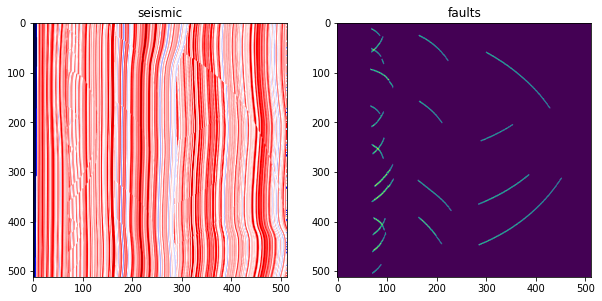

In [ ]:
# Visualize after resizing
ILINE=0
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(ai_resized[ILINE,:,:], cmap='seismic')
arr[0].set_title('seismic')
arr[1].imshow(fault_resized[ILINE,:,:])
arr[1].set_title('faults')

In [ ]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
def AugmentData(img, mask, target_shape_img, target_shape_mask):
    """
    Augments the data by using Keras' RandomFlip and RandomRotation layers
    to create random changes to images and masks
    """
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    X_new = np.zeros((augmentation*m,i_h,i_w,i_c), dtype=np.float32)
    y_new = np.zeros((augmentation*m,m_h,m_w,m_c), dtype=np.int32)

    # augment the data
    for index in range(len(img)):
      for i in range(augmentation):
          # use seed so img and mask receive same transformation
          seed = random.randint(0, 100)
          single_img = img[index]
          single_img = np.reshape(single_img, (single_img.shape[0],single_img.shape[1],1))
          print
          single_img = RandomCrop(size, size, seed=seed)(single_img)
          #single_img = RandomFlip(mode="horizontal_and_vertical", seed=seed)(single_img)
          #single_img = RandomRotation(factor=0.2, seed=seed)(single_img)
          single_mask = mask[index]
          single_mask = np.reshape(single_mask, (single_mask.shape[0],single_mask.shape[1],1))
          single_mask = RandomCrop(size, size, seed=seed)(single_mask)
          #single_mask = RandomFlip(mode="horizontal_and_vertical", seed=seed)(single_mask)
          #single_mask = RandomRotation(factor=0.2, seed=seed)(single_mask)
          X_new[index+i*m] = single_img
          y_new[index+i*m] = single_mask
          
    return np.concatenate((X_train, X_new)), np.concatenate((y_train, y_new))

In [ ]:
X_train, y_train = AugmentData(ai, fault, (size, size, 1), (size, size, 1))
print(X_train.shape)

(80, 512, 512, 1)


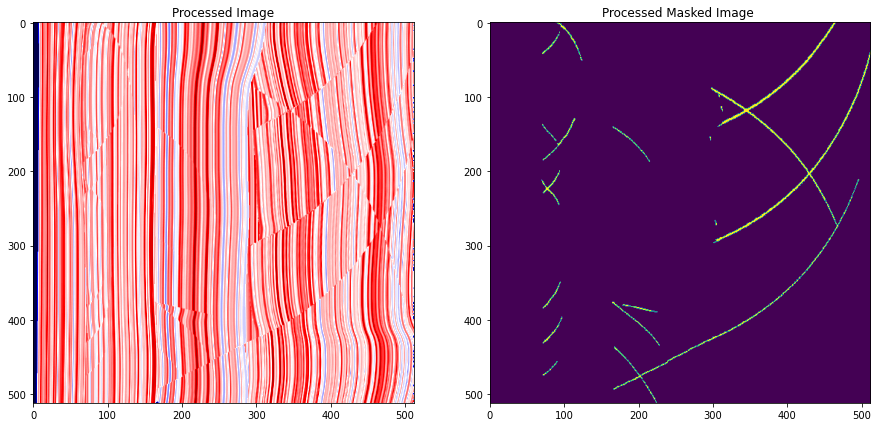

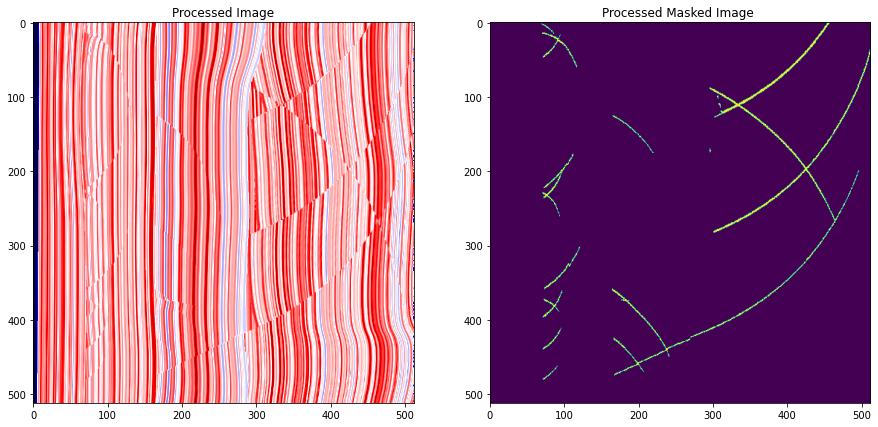

In [ ]:
# Visualize the output
for image_index in range(20,22):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X_train[image_index][:,:,0], cmap='seismic')
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_train[image_index,:,:,0])
    arr[1].set_title('Processed Masked Image ')

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=True)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(size,size,1), n_filters=32, n_classes=3)

In [ ]:
# This callback stops training when there is no improvement in the monitored
# metric after (patience) epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

In [ ]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
# Adamax and Nadam seem to perform best
unet.compile(optimizer=tf.keras.optimizers.Adamax(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=[callback], validation_data=(X_valid, y_valid))

Epoch 1/50
5/5 [==============================] - 22s 1s/step - loss: 0.2584 - accuracy: 0.9617 - val_loss: 0.0744 - val_accuracy: 0.9860
Epoch 2/50
5/5 [==============================] - 4s 770ms/step - loss: 0.0750 - accuracy: 0.9860 - val_loss: 0.0730 - val_accuracy: 0.9860
Epoch 3/50
5/5 [==============================] - 4s 765ms/step - loss: 0.0721 - accuracy: 0.9860 - val_loss: 0.0705 - val_accuracy: 0.9860
Epoch 4/50
5/5 [==============================] - 4s 766ms/step - loss: 0.0693 - accuracy: 0.9860 - val_loss: 0.0666 - val_accuracy: 0.9860
Epoch 5/50
5/5 [==============================] - 4s 769ms/step - loss: 0.0655 - accuracy: 0.9860 - val_loss: 0.0636 - val_accuracy: 0.9860
Epoch 6/50
5/5 [==============================] - 4s 771ms/step - loss: 0.0625 - accuracy: 0.9860 - val_loss: 0.0603 - val_accuracy: 0.9860
Epoch 7/50
5/5 [==============================] - 4s 769ms/step - loss: 0.0588 - accuracy: 0.9860 - val_loss: 0.0567 - val_accuracy: 0.9860
Epoch 8/50
5/5 [======

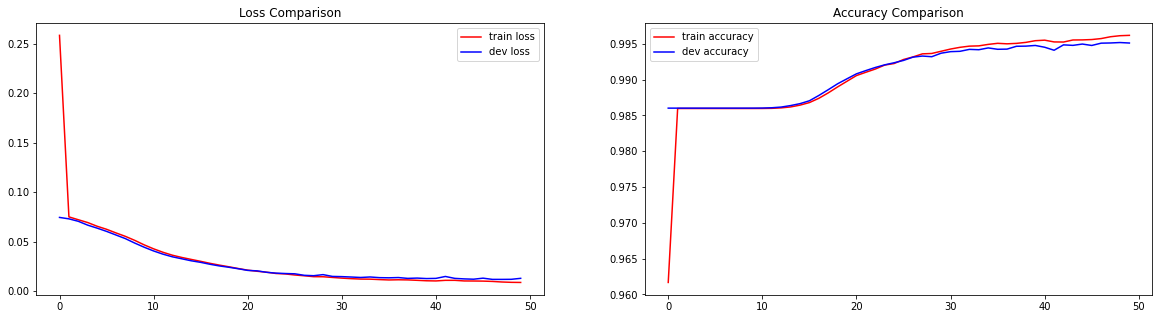

In [ ]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [ ]:
unet.evaluate(X_valid, y_valid)

1/1 [==============================] - 3s 3s/step - loss: 0.0129 - accuracy: 0.9951


[0.01289540808647871, 0.9951106309890747]

In [ ]:
# Helper function to get predicted mask
def getPredMask(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [ ]:
def IoU(index, smooth=1):
    pred_mask = getPredMask(index)
    y_true = y_valid[index]
    y_true = np.reshape(y_true, (1, size, size, 1)).astype('float32')
    y_pred = np.reshape(pred_mask, (1, size, size, 1)).astype('float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou.numpy()

In [ ]:
def diceScore(index, smooth=1):
    pred_mask = getPredMask(index)
    y_true = y_valid[index]  
    y_true = np.reshape(y_true, (1, size, size, 1)).astype('float32')
    y_pred = np.reshape(pred_mask, (1, size, size, 1)).astype('float32')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice.numpy()

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    pred_mask = getPredMask(index)
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    dice_score = diceScore(index)*100
    iou = IoU(index)*100
    plt.xlabel('Dice: ' + str(dice_score) + '%    IoU: ' + str(iou) +'%')
    arr[0].imshow(X_valid[index,:,:,0])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

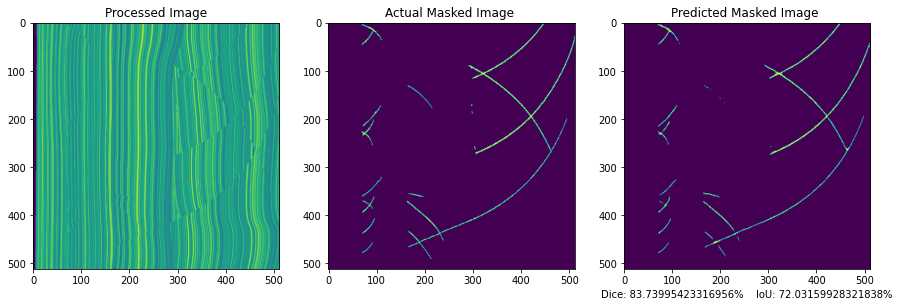

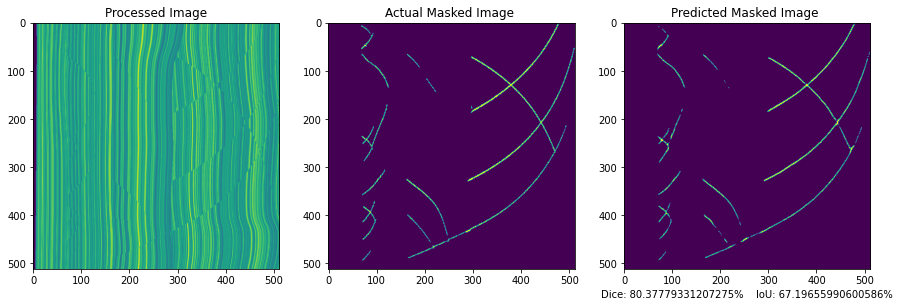

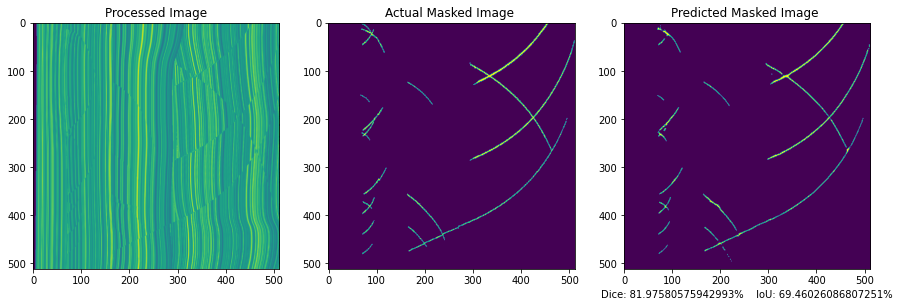

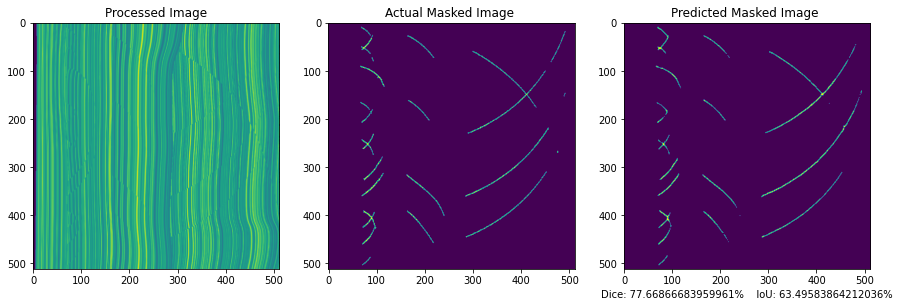

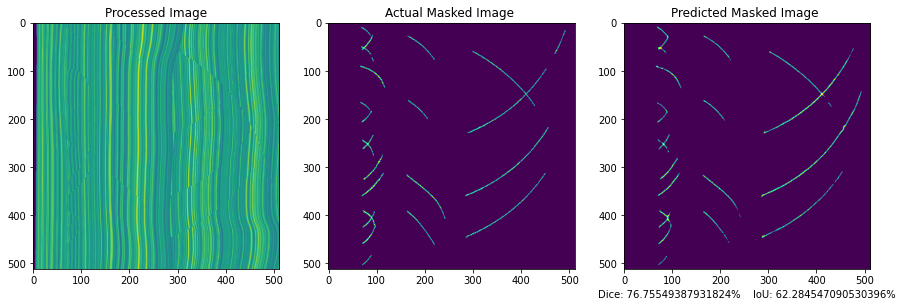

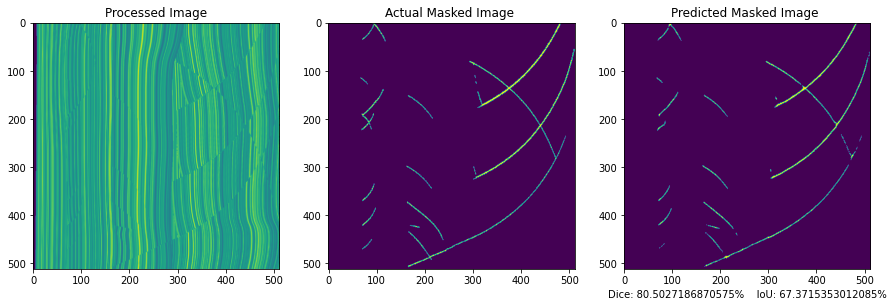

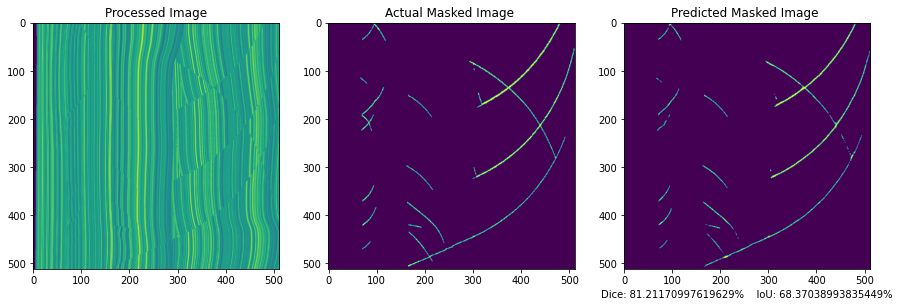

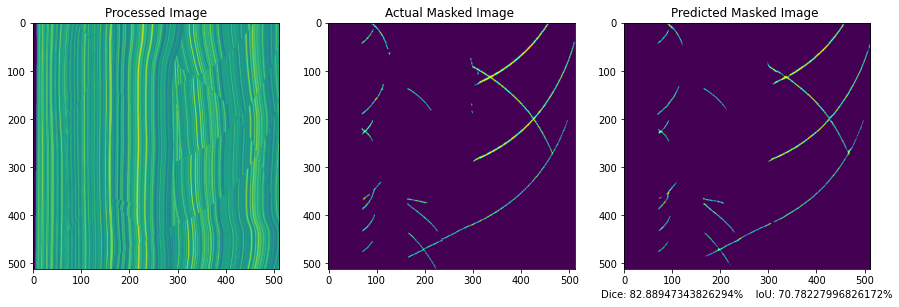

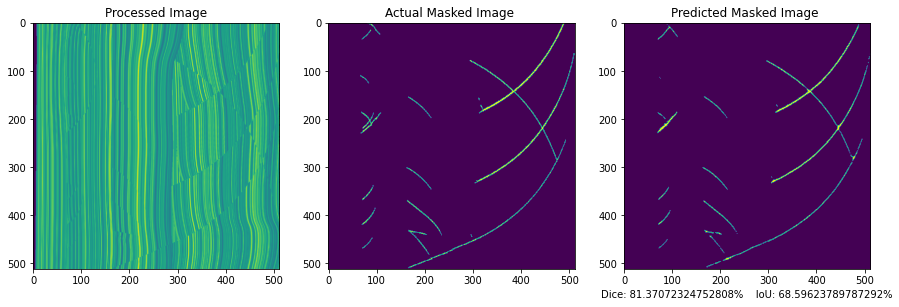

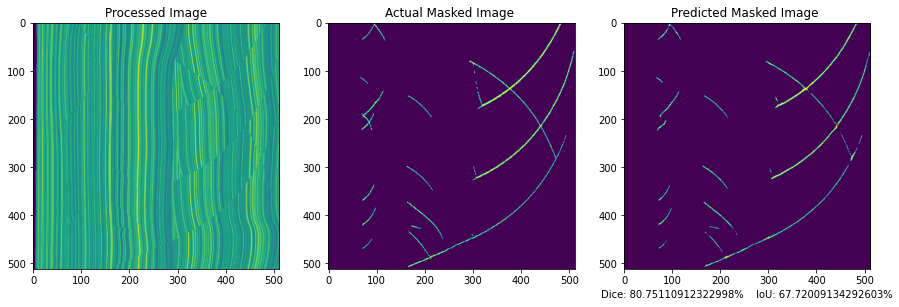

In [ ]:
for index in range(10):
    VisualizeResults(index)

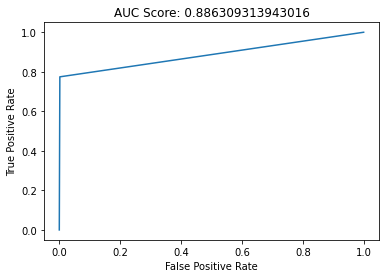

In [ ]:
y_true = []
y_pred = []

for index in range(len(y_valid)):
    pred = getPredMask(index)  # get prediction for each pixel in the image
    y_true.append(y_valid[index].flatten())  # flatten all targets
    y_pred.append(pred.numpy().flatten())  # flatten all predictions

# concatenate all predictions and targets:
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
# compute the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC Score: ' + str(auc_score))
plt.show()